# U-net as a Classifier

Treat U-net as a classification algorithm. If an image from the dataset contains at least one ship, then it is a positive observation. Otherwise, it is a negative observation.

If the output of U-net contains a number of pixels that is greater than or equal to a specified threshold, then it is classified as positive. Otherwise, it is classified as negative.

## Airbus 50-50 Testing

### Construct the Test Set

The test set contains the 6556 images with ships (positive) that were not used for training, as well as another 6556 randomly selected images that do not contain any ships (negative).

In [1]:
import os
import pathlib
import pandas as pd
import random
from fastai.vision.all import *
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw as Drawer
import ijson

In [2]:
# path to the airbus dataset and root
airbus_path = pathlib.Path('../airbus_dataset/').resolve()
root_path = pathlib.Path('..').resolve()

# get all images with ships
masks_rle = pd.read_csv('../airbus_dataset/train_ship_segmentations_v2.csv').set_index('ImageId')
ship_images = masks_rle[masks_rle['EncodedPixels'].apply(lambda x: isinstance(x, str))].index.unique().tolist()

# get the images with ships that were not used for training
train_valid = [f for f in os.listdir(airbus_path/'train_valid')]
ship_images_not_train = list(set(ship_images) - set(train_valid))

print('Number of images with ships:', len(ship_images))
print('Number of images with ships used for training:', len(train_valid))
print('Number of images with ships not used for training:', len(ship_images_not_train))

# get images without ships
all_images = [f for f in os.listdir(airbus_path/'train_v2')]
no_ship_images_all = list(set(all_images) - set(ship_images))

print()
print('Number of images in the entire Airbus dataset:', len(all_images))
print('Number of images without any ships:', len(no_ship_images_all))

# randomly select 6556 images without ships
no_ship_images = random.sample(no_ship_images_all, 6556)
print()
print('Number of randomly selected no ship images:', len(no_ship_images))

# construct the final test set
test_set = list(set(ship_images_not_train).union(set(no_ship_images)))
print()
print('Number of classifier test images:', len(test_set))


Number of images with ships: 42556
Number of images with ships used for training: 36000
Number of images with ships not used for training: 6556

Number of images in the entire Airbus dataset: 192556
Number of images without any ships: 150000

Number of randomly selected no ship images: 6556

Number of classifier test images: 13112


## U-net Predictions

Generate the predictions of U-net for the images in the classifier test set.

### Load the Pre-trained Model

We first need to create the architecture the same way we did for training, then load the model from *models/unet_googlenet.pth*.

/home/tudor/satcen-ship-detection/env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tudor/satcen-ship-detection/env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


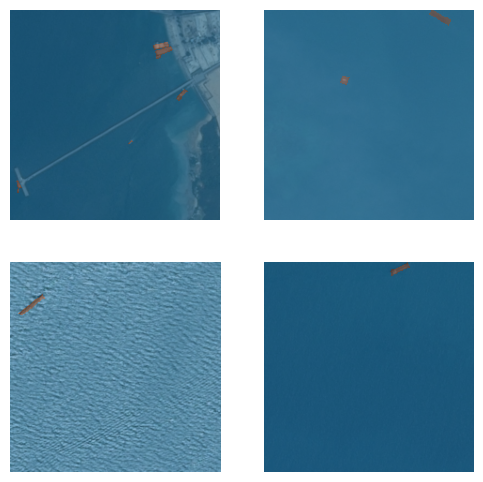

In [3]:
# define a function that gets the label for a given image
def label_func(fn): return airbus_path/"train_v2_labels"/f"{fn.stem}_P.png"

# create a datablock
dblock = DataBlock(
    blocks=(ImageBlock, MaskBlock(np.loadtxt(airbus_path/'codes.txt', dtype=str))),
    get_items=get_image_files,
    get_y=label_func,
    splitter=RandomSplitter(), # splits data into training and validation (0.2 for validation)
    item_tfms=Resize(224) # resize images to 224x224
)

# load the data in the datablock
torch.cuda.init()
dls = dblock.dataloaders(airbus_path/'train_valid/', bs=4, device=torch.device('cuda'))

dls.show_batch(max_n=4)

# create the learner
unet = unet_learner(dls, googlenet,
    self_attention=True,
    loss_func=FocalLoss(),
    lr=1e-4
)

# load the model
unet.load('unet_googlenet')

### Generate the Predictions

1. Perform inference on the original image using U-net
2. Threshold the image at 0: pixel values greater than 0 will be 1, and less than 0 will be 0
3. Count the number of non-zero pixels (ship pixels)
4. Determine the label of the image based on the number of ship pixel
    * At least 1 ship pixel -> True
    * 0 ship pixels -> False

66ca97cd4.jpg


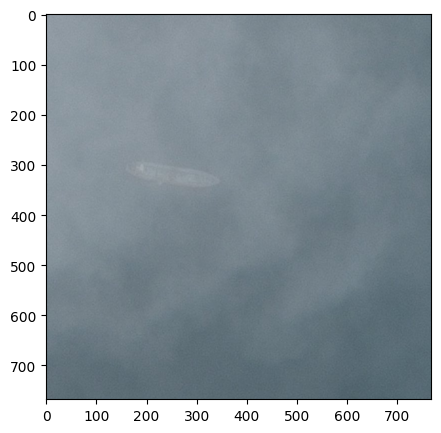

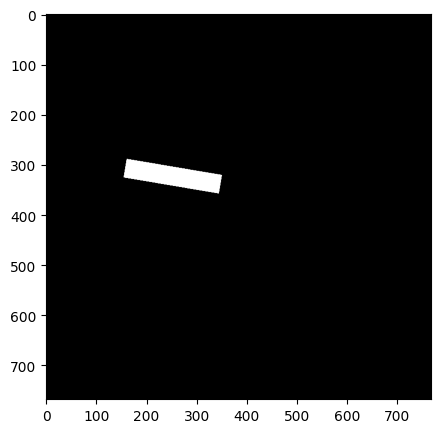

Predicted label: True


In [4]:
# generate the full image mask of an image from run-length encoding
def get_image_mask(image_id):
    
    # create a 1D array equal to legnth*width of the initial image 
    image_mask = np.zeros(768*768)

    # get all the ship masks in the image
    # slicing necessary to ensure loc returns df of masks, not actual value of mask
    #
    # need to check if the image has at least a ship
    if image_id in ship_images:
        for mask in masks_rle.loc[image_id:image_id]['EncodedPixels']: 
            mask = mask.split()
            mask = [int(i) for i in mask]
            for i in range(0, len(mask), 2):
                image_mask[mask[i]:mask[i]+mask[i+1]] = 1

    # reshape the image mask
    image_mask = image_mask.reshape([768, 768]).T
    
    return image_mask

# determine the class of an image (True or False)
def get_class_label(image_id):

    # perform inference on the image
    with unet.no_bar(), unet.no_logging(): _, _, pred = unet.predict(airbus_path/'train_v2'/image_id)
    pred = pred.numpy()[1]

    # threshold the image at 0
    pred[(pred > 0)] = 1
    pred[(pred < 0)] = 0

    # plt.imshow(pred, cmap='Greys_r')
    # plt.show()

    # determine the number of pixels identified as ship (pixel value = 1)
    ship_pixels = np.count_nonzero(pred)
    # print(ship_pixels)

    # determine the class of the image based on the number of ship pixels within it
    if ship_pixels > 0:
        return True
    else:
        return False

# load an image
img_id = test_set[7000]
img = np.array(Image.open('../airbus_dataset/train_v2/' + img_id))

# load the image mask
img_mask = np.array(Image.fromarray(get_image_mask(img_id)))

# display the image
print(img_id)
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.show()
plt.figure(figsize=(5,5))
plt.imshow(img_mask, cmap='Greys_r')
plt.show()

# predict the label of the image
print('Predicted label:', get_class_label(img_id))

### Calculate the Accuracy

1. Determine the label of each test image
2. Check if the prediction is correct:
    * label = True and image is in *ship_images* (contains at least one ship)
    * label = False and image is not in *ship_images* (does not contain any ships)

In [8]:
# loop through all the images in the test set
tp = 0
tn = 0
for im in test_set:
    
    # get the predicted class of the image
    pred_class = get_class_label(im)

    # check if the prediction is correct
    if im in ship_images and pred_class == True:
        tp += 1
    elif im not in ship_images and pred_class == False:
        tn += 1

print('True Positives:', tp)
print('True Negatives:', tn)
print('Accuracy:', (tp + tn) / len(test_set))

True Positives: 6013
True Negatives: 6219
Accuracy: 0.9328859060402684


## Satcen Testing

Test the trained Unet model on the entire Satcen dataset.

### Load the Dataset

Load the entire Satcen dataset.
Transform the *.json* file provided in order to obtain binary classes for each image:
- at least 1 ship -> positive class (1)
- no ships -> negative class (0)

In [5]:
# load the image filenames
satcen = [f for f in os.listdir(root_path/'satcen_dataset/pictures')]

# load the json file containing bounding boxes
satcen_json = [entry for entry in ijson.items(open('../satcen_dataset/SatCen_skiffs256.json'), 'batch.annotations.item')]

# pre-process the json
satcen_json = list(map(lambda x: {'name': x['name'], 'bounding_boxes': [e['data'] for e in x['objects']]}, satcen_json))

# transform the json file to obtain binary class labels
# store the labels in a dict where keys represent images and values represent classes
ground_truth = dict()

# loop through the json
for entry in satcen_json:
    ground_truth[entry['name']] = 1 if len(entry['bounding_boxes']) > 0 else 0

# add ground truth for the entries that are not annotated
for entry in set(satcen) - set(e['name'] for e in satcen_json):
    ground_truth[entry] = 0

# print some statistics
print('Number of satcen images:', len(satcen))
print('Number of annotated images:', len(satcen_json))
print()
print('Positive observations:', len(list(filter(lambda v: v == 1, ground_truth.values()))))
print('Negative observations:', len(list(filter(lambda v: v == 0, ground_truth.values()))))
    

Number of satcen images: 2170
Number of annotated images: 1833

Positive observations: 1525
Negative observations: 645


### Generate Ground Truth Labels

Compute ground truth for images in the Satcen dataset based on the given bounding boxes.
Ground truth labels should be saved as *.png* files in the *satcen_dataset/pictures* folder.

In each ground truth image:
- 0 pixel value represents background pixel
- 1 pixel value represents ship pixel

281-0-1024.png


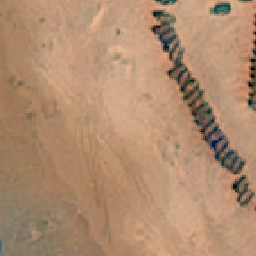

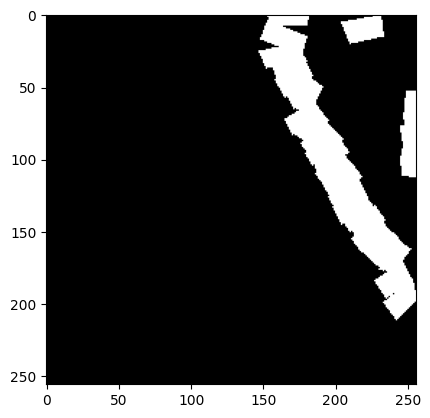

In [6]:
# compute segmentation mask of a Satcen image based on its bounding box
# @param img_name - filename of the image for which to compute ground truth
# @param bounding_boxes - list of bounding boxes for that image
# @return mask - PIL image representing the mask of the given image
def get_image_mask_satcen(img_name, bounding_boxes):
    
    # create the skeleton of the segmentation mask
    # size is constant for satcen dataset, 256 x 256
    mask = Image.fromarray(np.zeros((256, 256)))

    # get a drawer object
    draw = Drawer.Draw(mask)

    # loop through the bounding boxes
    for bb in bounding_boxes:

        # convert coordinates to required format
        coords = [(c['x'], c['y']) for c in bb]

        # draw the bounding box on the image
        draw.polygon(coords, fill=1)

    return mask

test_im = satcen[200]
print(test_im)

bbx = [e for e in satcen_json if e['name'] == test_im][0]['bounding_boxes']

m = get_image_mask_satcen(test_im, bbx)

Image.open(root_path/'satcen_dataset/pictures'/f'{test_im}').show()
plt.imshow(np.array(m), cmap='gray')


### Run Unet Testing on Satcen

Test Unet on the entire Satcen dataset and save the results as *.npy* files in the *satcen_dataset/results_unet* folder.

In [7]:
# # remove all files currently in results_unet
# for f in os.listdir(root_path/'satcen_dataset/results_unet'):
#     os.remove(root_path/'satcen_dataset/results_unet'/f'{f}')

# # loop through all images in the dataset
# for img in satcen:

#     # generate prediction
#     with unet.no_bar(), unet.no_logging(): _, _, pred = unet.predict(root_path/'satcen_dataset/pictures'/img)
#     pred = pred.numpy()[1]
        
#     # save prediction as .npy
#     np.save(root_path/'satcen_dataset/results_unet/'f'{img[:-4]}_L', pred)

print('Number of predictions:', len(os.listdir(root_path/'satcen_dataset/results_unet')))


Number of predictions: 2170


### Measure Model Performance

Calculate the following metrics for different thresholds (if a pixel value in the raw Unet output is greater than the threshold, then it is considered a ship pixel):
- Accuracy
- TP, TN, FP, FN
- True positive rate (TPR)
- False positive rate (FPR)

Plot ROC curve for all thresholds considered.

In [8]:
# load the raw unet outputs and
# save them in a dict where key represents image name and value represents output
unet_outputs = dict()
for filename in satcen:
    unet_outputs[filename] = np.load(root_path/'satcen_dataset/results_unet/'f'{filename[:-4]}_L.npy')

print('Number of outputs loaded:', len(unet_outputs))

Number of outputs loaded: 2170


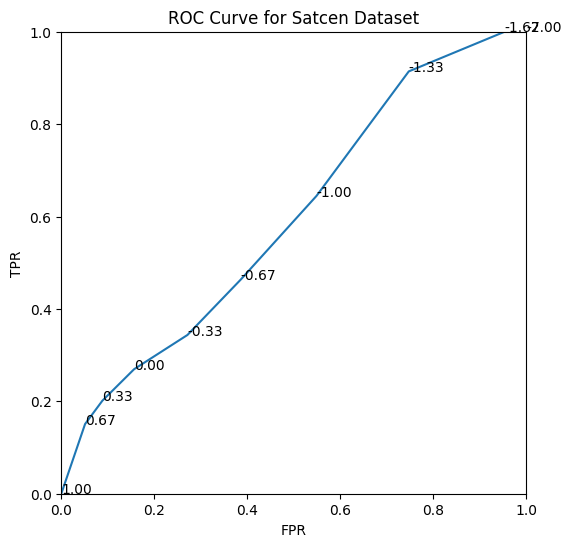

In [9]:
# list of thresholds to consider
thresholds = np.linspace(-2, 1, 10)

# dict to store metrics for each threshold
metrics = dict()

# loop through the thresholds
for t in thresholds:

    # initialize tp, tn, fp, fn
    tp = 0 # true positives
    tn = 0 # true negatives
    fp = 0 # fapse positives
    fn = 0 # false negatives
    
    # loop through all images in the dataset
    for img in satcen:

        # get the raw unet output for that image
        pred = np.copy(unet_outputs.get(img))

        # sanity check
        if type(pred) == NoneType:
            raise Exception(f'Could not find output for {img}')

        # threshold the raw output at the current threshold value
        pred[pred > t] = 1
        pred[pred <= t] = 0

        # determine the predicted class for the current image
        pred_class = 1 if np.count_nonzero(pred) > 0 else 0

        # get the ground truth for the current image
        ground_truth_class = ground_truth.get(img)

        # determine the type of prediction (tp, tp, fp, fn)
        if pred_class == 1:
            if ground_truth_class == 1: # predicted positive, actual positive
                tp += 1
            elif ground_truth_class == 0: # predicted positive, actual negative
                fp += 1
        elif pred_class == 0:
            if ground_truth_class == 1: # predicted negative, actual positive
                fn += 1
            elif ground_truth_class == 0: # predicted negative, actual negative
                tn += 1

    # calculate TPR and FPR
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)

    # store metrics
    metrics[t] = {
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'tpr': tpr,
        'fpr': fpr
    }

    # print metrics for this threshold
    # print(f'### Threshold {t} ###')
    # print('TP:', tp)
    # print('FP:', fp)
    # print('TN:', tn)
    # print('FN:', fn)
    # print('TPR:', tpr)
    # print('FPR:', fpr)
    # print()

# plot ROC curve
plt.figure(figsize=(6,6))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve for Satcen Dataset')
plt.xlim([0,1])
plt.ylim([0,1])

# extract tpr, fpr and thresholds from the metrics
tprs = [e['tpr'] for e in metrics.values()]
fprs = [e['fpr'] for e in metrics.values()]
ts = list(metrics.keys())

plt.plot(fprs, tprs)
for i in range(len(ts)):   
    plt.annotate("{0:.2f}".format(ts[i]), (fprs[i], tprs[i]))
plt.show()     

In [9]:
# construct the complete airbus test set:
# - all images without ships
# - images with ships not used for training
airbus_test_all = list(set(ship_images_not_train).union(set(no_ship_images_all)))
print('Size of complete Airbus test dataset:', len(airbus_test_all))

# remove all files in the airbus_dataset/unet_results folder
# for f in os.listdir(airbus_path/'results_unet'):
#     os.remove(airbus_path/'results_unet'/f'{f}')

# get unet predictions for each image in the comlete test set
# remaining = list(set(map(lambda x: x[:-4], airbus_test_all)) - set([f[:-6] for f in os.listdir(airbus_path/'results_unet')]))
# print(len(remaining))

# for img in remaining:
#     img += '.jpg'
#     # predict the label of the image
#     try:
#         with unet.no_bar(), unet.no_logging(): _, _, pred = unet.predict(airbus_path/'train_v2'/img)
#         pred = pred.numpy()[1]

#         # save prediction in airbus_dataset/unet_results with "_L" suffix
#         np.save(airbus_path/'results_unet/'f'{img[:-4]}_L', pred)
#     except Exception as e:
#         print(e)
#         print(img)


Size of complete Airbus test dataset: 156556


In [16]:
# load saved results
results_airbus = os.listdir(airbus_path/'results_unet')
print('Number of Airbus results:', len(results_airbus))

Number of Airbus results: 156555


### Threshold -1.0 ###
TP: 6530
FP: 52751
TN: 97248
FN: 26
TPR: 0.9960341671751067
FPR: 0.35167567783785225
Accuracy: 0.662885247995912

### Threshold -0.75 ###
TP: 6494
FP: 36887
TN: 113112
FN: 62
TPR: 0.9905430140329469
FPR: 0.2459149727664851
Accuracy: 0.7639870971862923

### Threshold -0.5 ###
TP: 6429
FP: 24793
TN: 125206
FN: 127
TPR: 0.9806284319707138
FPR: 0.1652877685851239
Accuracy: 0.8408227140621507

### Threshold -0.25 ###
TP: 6271
FP: 14872
TN: 135127
FN: 285
TPR: 0.9565283709579011
FPR: 0.099147327648851
Accuracy: 0.9031841844719108

### Threshold 0.0 ###
TP: 6013
FP: 7581
TN: 142418
FN: 543
TPR: 0.9171751067724222
FPR: 0.05054033693557957
Accuracy: 0.9481076937817381

### Threshold 0.25 ###
TP: 5476
FP: 3092
TN: 146907
FN: 1080
TPR: 0.8352654057352044
FPR: 0.02061347075647171
Accuracy: 0.973351218421641

### Threshold 0.5 ###
TP: 4686
FP: 972
TN: 149027
FN: 1870
TPR: 0.714765100671141
FPR: 0.006480043200288002
Accuracy: 0.9818466353677622

### Threshold 0.75 ###
TP: 4024

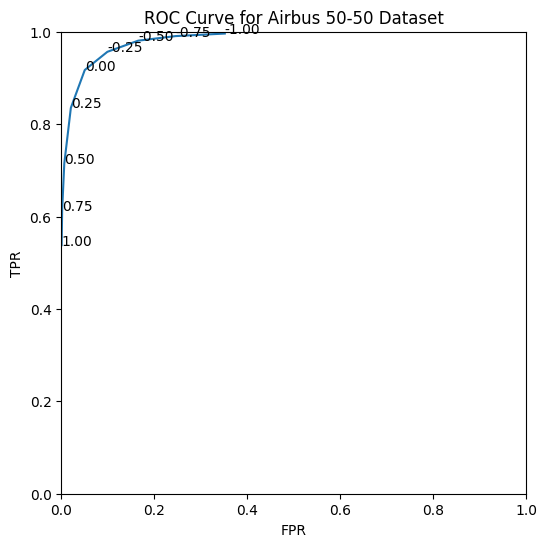

In [49]:
# list of thresholds to consider
thresholds_airbus = np.linspace(-1, 1, 9)

# dict to store metrics for each threshold
metrics_airbus = dict()

# initialize metrics dict
for t in thresholds_airbus:
    metrics_airbus[t] = {
        'tp': 0,
        'fp': 0,
        'tn': 0,
        'fn': 0
    }
    
# loop through all images in the dataset
for img in results_airbus:

    # load the prediction
    pred = np.load(airbus_path/'results_unet'/img)
    img = img[:-6] + '.jpg'

    # loop through the thresholds
    for t in thresholds_airbus:

        # determine the predicted class for the current image
        pred_class = 1 if np.any(pred > t) else 0

        # determine the type of prediction (tp, tp, fp, fn)
        if pred_class == 1:
            if img in ship_images: # predicted positive, actual positive
                metrics_airbus[t]['tp'] += 1
            else: # predicted positive, actual negative
                metrics_airbus[t]['fp'] += 1
        elif pred_class == 0:
            if img in ship_images: # predicted negative, actual positive
                metrics_airbus[t]['fn'] += 1
            else: # predicted negative, actual negative
                metrics_airbus[t]['tn'] += 1

    del pred

# print results
for t in thresholds_airbus:

    tp = metrics_airbus[t]['tp']
    fp = metrics_airbus[t]['fp']
    tn = metrics_airbus[t]['tn']
    fn = metrics_airbus[t]['fn']

    # calculate TPR and FPR
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)

    # update metrics
    metrics_airbus[t]['tpr'] = tpr
    metrics_airbus[t]['fpr'] = fpr

    # print metrics for this threshold
    print(f'### Threshold {t} ###')
    print('TP:', tp)
    print('FP:', fp)
    print('TN:', tn)
    print('FN:', fn)
    print('TPR:', tpr)
    print('FPR:', fpr)
    print('Accuracy:', (tp + tn) / (tp + tn + fp + fn))
    print()

# plot ROC curve
plt.figure(figsize=(6,6))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve for Airbus 50-50 Dataset')
plt.xlim([0,1])
plt.ylim([0,1])

# extract tpr, fpr and thresholds from the metrics
tprs = [e['tpr'] for e in metrics_airbus.values()]
fprs = [e['fpr'] for e in metrics_airbus.values()]
ts = list(metrics_airbus.keys())

plt.plot(fprs, tprs)
for i in range(len(ts)):   
    plt.annotate("{0:.2f}".format(ts[i]), (fprs[i], tprs[i]))
plt.show()

In [48]:
for t in metrics_airbus.keys():
    print(t)
    print(metrics_airbus[t], '\n')

-1.0
{'tp': 6530, 'fp': 52751, 'tn': 97248, 'fn': 26, 'tpr': 0.9960341671751067, 'fpr': 0.35167567783785225} 

-0.75
{'tp': 0, 'fp': 43381, 'tn': 113174, 'fn': 0} 

-0.5
{'tp': 0, 'fp': 31222, 'tn': 125333, 'fn': 0} 

-0.25
{'tp': 0, 'fp': 21143, 'tn': 135412, 'fn': 0} 

0.0
{'tp': 0, 'fp': 13594, 'tn': 142961, 'fn': 0} 

0.25
{'tp': 0, 'fp': 8568, 'tn': 147987, 'fn': 0} 

0.5
{'tp': 0, 'fp': 5658, 'tn': 150897, 'fn': 0} 

0.75
{'tp': 0, 'fp': 4305, 'tn': 152250, 'fn': 0} 

1.0
{'tp': 0, 'fp': 3645, 'tn': 152910, 'fn': 0} 



### Threshold -1.0 ###
TP: 6530
FP: 52751
TN: 97274
FN: 0
TPR: 1.0
FPR: 0.35161473087818695
Accuracy: 0.6630513238159114